<a href="https://colab.research.google.com/github/avkornaev/Fast_AI_course/blob/main/IRI_defects_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Установка библиотек**

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

**Импорт библиотек**

In [2]:
from fastai.vision.all import *

**Загрузка данных**

In [3]:
path =  Path('/content/gdrive/MyDrive/work/Tribology/IRI_dataset/Training')

In [4]:
path.ls()

(#2) [Path('/content/gdrive/MyDrive/work/Tribology/IRI_dataset/Training/Norm'),Path('/content/gdrive/MyDrive/work/Tribology/IRI_dataset/Training/Bad')]

Скачивание файлов изображений.

In [5]:
files = get_image_files(path)

In [6]:
len(files)

214

In [7]:
files[0],files[2]

(Path('/content/gdrive/MyDrive/work/Tribology/IRI_dataset/Training/Norm/img_thermal_1637761638400.jpg'),
 Path('/content/gdrive/MyDrive/work/Tribology/IRI_dataset/Training/Norm/img_thermal_1637761920622.jpg'))

**Создание датасета**

Используется DataBlock и DataLoader, которые считывает разметку данных с названия папки с помощью функции parent_label.



In [8]:
IRI_data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label)

In [9]:
IRI_data = IRI_data.new(item_tfms=Resize(224),batch_tfms=aug_transforms(mult=2))

In [10]:
dls = IRI_data.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


Просмотр примера изображений

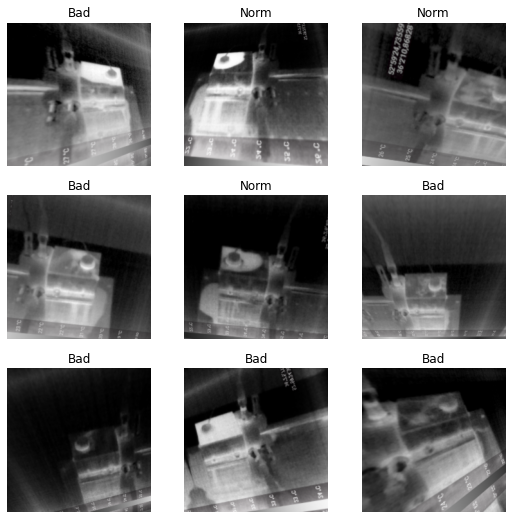

In [11]:
dls.show_batch()

**Обучение**

In [12]:
#??cnn_learner

In [13]:
learn = cnn_learner(dls,resnet34,metrics=error_rate,pretrained=True,lr=0.00145)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Целевая функция

In [14]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

Метод поиска экстремума

In [15]:
learn.opt_func

<function fastai.optimizer.Adam>

Подбор скорости обучения
Строку ниже можно закоментировать. Для случая трансферного обучения resnet18 рекомендуемая скорость обучения lr
SuggestedLRs(valley=0.0014454397605732083)

для resnet34
SuggestedLRs(valley=0.00363078061491251

SuggestedLRs(valley=0.00363078061491251)

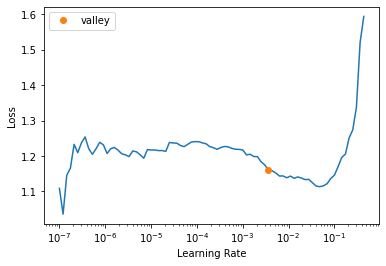

In [16]:
 learn.lr_find()

In [17]:
learn.fine_tune(50)

epoch,train_loss,valid_loss,error_rate,time
0,1.157005,1.361770,0.619048,00:51


epoch,train_loss,valid_loss,error_rate,time
0,1.057486,0.943705,0.571429,01:08
1,1.282606,0.838810,0.476190,01:08
2,1.185271,0.843602,0.476190,01:08
3,1.167904,0.815057,0.452381,01:08
4,1.144645,0.847112,0.500000,01:08
5,1.138666,0.828751,0.476190,01:08
6,1.145262,0.763956,0.380952,01:08
7,1.098482,0.761861,0.380952,01:08
8,1.091990,0.741462,0.357143,01:08
9,1.087976,0.653544,0.285714,01:08


**Результаты**

Предсказание для любого конкретного изображения

In [18]:
learn.predict(files[101]),files[101]

(('Bad', TensorBase(0), TensorBase([0.9968, 0.0032])),
 Path('/content/gdrive/MyDrive/work/Tribology/IRI_dataset/Training/Bad/img_thermal_1637833041811.jpg'))

Визуализация предсказаний.

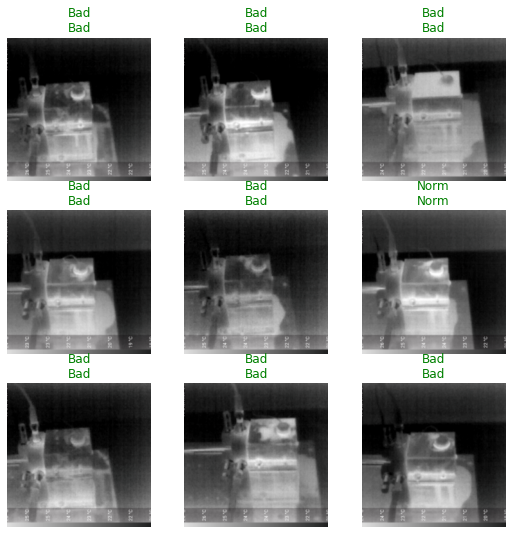

In [19]:
learn.show_results()

**Оценка точности**

Матрица ошибок

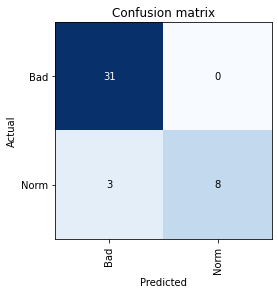

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [21]:
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(tn, fp, fn, tp)

31 0 3 8


In [22]:
sensitivity = tp/(tp + fn)
sensitivity

0.7272727272727273

Специфичность

In [23]:
specificity = tn/(fp + tn)
specificity

1.0

Positive Predictive Value (PPV)

In [24]:
ppv = tp/(tp+fp)
ppv

1.0

Negative Predictive Value (NPV)

In [25]:
npv = tn/(tn+fn)
npv

0.9117647058823529

Calculating Accuracy

In [26]:
acc = (tp+tn)/(tp+tn+fp+fn)
acc

0.9285714285714286

Ссылки:
https://github.com/avkornaev/Fast_AI_course/blob/main/02_production_v3_online.ipynb

https://docs.fast.ai/tutorial.medical_imaging.html

https://docs.fast.ai/data.block.html#DataBlock


